# MODIS Water Random Forest

Version: 0.2.1

Date modified: 03.23.2022

Modified by: Caleb Spradlin

In [1]:
import csv
import datetime
import glob
import joblib
import numpy as np
import os
import pandas as pd
from pathlib import Path
from pprint import pprint
import sys
import time

from sklearn.ensemble import RandomForestClassifier as skRF
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.inspection import permutation_importance

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

#GDAL Stuff
from osgeo import gdalconst
from osgeo import gdal

#sys.path.append('../')
#import notebook_util as nu

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline


There are different versions of the datset? different folders with the "training_data", 
v1.0.0  v1.0.1  v1.1.0  v2.0.0  v3.0.0  v4.0.0  v4.1.0  v4.2.0


From Caleb Spradlin Feb 21, 2023

"
v2.0.0 = Completely random pulling of data from all tiles (including high latitude tiles)
v3.0.0 = Completely random pulling of data from all tiles (including high latitude tiles), 
some targeted training data for ice (h16v02, h17v02, h11v02)v4.0.0 = Disregard. 
Pulling random points from hand picked days for h09v05, h11v10, h12v09, h18v03

v4.1.0 + v4.2.0 = Pulling random points from set of hand picked days for all tiles,
some targeted training data for ice (h16v02, h17v02, h11v02). 
I think we lowered the number of points in v4.2.0

I guess if you are looking to start with a random base set that still has all of the metadata cols and some targeted training data developed by a scientist to help tackle ice, v3.0.0 might be the one to start with. I know v2.0.0 doesn't have the metadata cols to it. Btw all of these were automatically balanced between land and water within a certain percentage.

path to the full 2 billion points:
/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/AGU/MOD09.Total.all.2334352265.09052022.parquet.gzip

"


THOUGHTS OF THINGS TO TRY:

-try reducing dataset with more weight on the 1 cases than the 0 (more weight to water than land)
-try more weight on the 1 cases than the 0 (more weight to water than land)
-try running RFA with different input variables dropped?"




Per Mark 2/23/23 
-v4.2, look at different days/years/tile that specific to the QA mask
-look at the raster file of where the targeted data are at
-augment the v4.2 with more targeted land/water after split training/testing

In [83]:
FIGURE_OUTPUT_DIR = '/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp'
RASTER_OUTPUT_DIR = '/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp'
MODEL_OUTPUT_DIR = '/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/'


#CHANGE HERE FOR THE DIFFERENT VERSIONS 
training_data_basepath = '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v3.0.0'

qaMaskPath = '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/qa'
waterMaskPath = '/explore/nobackup/people/mcarrol2/MODIS_water/v5_outputs'

test_data_basepath = '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/test_data/'

GPU = True
#Global for v3 not v4
TILE = 'GLOBAL'
MODEL = 'rf'

#This is the data train/test split
TEST_RATIO = 0.2
#random state variable 
RANDOM_STATE = 42
LABEL_NAME = 'water'
DATA_TYPE = np.int16
# Columns that are offset, years, julian days, etc (always need to be dropped).
offsets_indexes = ['x_offset', 'y_offset', 'year', 'julian_day', 'tileID']
# Columns that the user wants to drop for training purposes. 
colsToDrop = [] # ['sur_refl_b03_1','sur_refl_b04_1','sur_refl_b05_1','ndwi1','ndwi2']
colsToDropTraining = colsToDrop.copy()
colsToDropTraining.extend(offsets_indexes)
v_names = ['sur_refl_b01_1','sur_refl_b02_1','sur_refl_b03_1',
           'sur_refl_b04_1','sur_refl_b05_1','sur_refl_b06_1',
           'sur_refl_b07_1','ndvi','ndwi1','ndwi2']

In [82]:
colsToDrop

[]

In [3]:
colsToDropTraining

['x_offset', 'y_offset', 'year', 'julian_day', 'tileID']

In [40]:
def load_data(fpath, colsToDrop, yCol='water', testSize=0.2, randomState=42, 
              dataType=np.float32, cpu=True, splitXY=False, trainTestSplit=False,
             applyLog=False, imbalance=False, frac=0.1, land=False, multi=False, 
              multisample=1000000):
    """
    Simple helper function for loading data to be used by models
    :pa
    ram fpath: Path to the data to be ingested.
    :param dataType: Data type to convert ingested data to.
    :param colsToDrop: Columns which are not necessary, from which to drop.
    :param testSize: Ration to
    """
    if multi:
        all_dfs = [pd.read_csv(path_) for path_ in fpath]
        df = pd.concat(all_dfs).sample(n=multisample, random_state=randomState)
        print('DF length: {}'.format(len(df.index)))
    else:   
        df = pd.read_parquet(fpath) if '.parquet' in fpath else pd.read_csv(fpath)
    #combine all the dataset features
    df = df[df['sur_refl_b01_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b07_1'] + df['sur_refl_b02_1'] != 0]
    df = df[df['sur_refl_b06_1'] + df['sur_refl_b02_1'] != 0]
    df = df.drop(columns=colsToDrop)
    #drop out all the data that is NaNs or Infinity
    cleanedDF = df[~df.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0).astype(dataType)
    #If wanting to apply a log function 
    if applyLog:
        for col in cleanedDF.drop([yCol], axis=1).columns:
            print('Applying log1p func to {}'.format(col))
            cleanedDF[col] = np.log1p(cleanedDF[col])
        cleanedDF = cleanedDF[~cleanedDF.isin([np.NaN, np.inf, -np.inf]).any(1)].dropna(axis=0)
    df = None
    print(cleanedDF)
    
    if imbalance:
        groupedDF = cleanedDF.groupby('water')
        dfs = [groupedDF.get_group(y) for y in groupedDF.groups]
        sampledDF = dfs[1].sample(frac=frac)if land else dfs[0].sample(frac=frac)
        concatDF = sampledDF.append(dfs[0]) if land else sampledDF.append(dfs[1])
        concatDF = concatDF.sample(frac=1)
        concatDF = concatDF.reset_index()
        cleanedDF = concatDF.drop(columns=['index'])
    if not splitXY:
        return cleanedDF
    X = cleanedDF.drop([yCol], axis=1).astype(dataType)
    y = cleanedDF[yCol].astype(dataType)
    if trainTestSplit:
        return train_test_split(X, y, test_size=TEST_RATIO)
    else:
        return X, y

## Data 
- Read in to cuDF or pandas Dataframe
- Drop unnecessary columns
- Clean data
- Split into Xs and Ys
- Train-test split

In [4]:
#glob_string = os.path.join(training_data_basepath,'MOD*{}*.parquet.gzip'.format(TILE))
glob_string = '/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v3.0.0/*{}*.parquet.gzip'.format(TILE)
data_paths = [fv for fv in glob.glob(glob_string)]
data_path = data_paths[0]
pprint(data_paths)

['/explore/nobackup/projects/ilab/data/MODIS/MODIS_WATER_ML/training_data/v3.0.0/MOD09_GLOBAL_5599995_3_0_2.parquet.gzip']


In [44]:
%%time

#What does imbalance do?
#change the frac to 0.2 if you want 20% of the dataset to have 0 and the other 80 to have 1 I believe
X_train, X_test, y_train, y_test = load_data(fpath=data_path,
                                             colsToDrop=colsToDropTraining,
                                             dataType=DATA_TYPE,
                                             cpu=True,
                                             imbalance=True, 
                                             frac=0.2,
                                             splitXY=True,
                                             trainTestSplit=True,
                                             multi=False)



print(y_train)
print(X_train)


ones_train = np.count_nonzero(y_train)
zeros_train = len(y_train)-ones_train
print('Training percent',zeros_train/len(y_train),ones_train/len(y_train))
ones_test = np.count_nonzero(y_test)
zeros_test = len(y_test)-ones_test
print('Testing percent',zeros_test/len(y_test),ones_test/len(y_test))

         water  sur_refl_b01_1  sur_refl_b02_1  sur_refl_b03_1  \
0            1             729             780            1050   
1            1            1758             955            1320   
2            0             136            2649              87   
3            0             610            1488             393   
4            0             765            2892             355   
...        ...             ...             ...             ...   
5599990      1             324             202             202   
5599991      0            1461            2315             599   
5599992      1              23              -4             132   
5599993      1              20              -8             147   
5599994      1             422             321             393   

         sur_refl_b04_1  sur_refl_b05_1  sur_refl_b06_1  sur_refl_b07_1  \
0                   947             640             394             204   
1                  1598             614             578  

In [42]:
# #Determining how many 1/0 there are

# ##################
# #ONLY RUN IF YOU WANT THE TRAINING DATASET TO HAVE MORE 1 THAN 0 BUT LEAVE THE TESTSET ALONE
# #the "imbalance" option does it before the train/test split so the train/test/valid of this case all have the same 
# #imbalance which doesnt represent the full dataset. Granted its still randomly chosen data so
# ##################


# percent_zero = 0.2

# water_ids = np.where(y_train > 0.5)[0]
# #land_ids = np.random.choice(np.where(y_train < 0.5)[0],int(len(water_ids)*percent_zero),replace=False)
# land_ids = np.where(y_train < 0.5)[0][:int(len(water_ids)*percent_zero)]
# print(land_ids)

# #Concatenating though with all ones first then all 0's
# total_train_ids = np.concatenate([water_ids,land_ids])
# print(len(total_train_ids),len(y_train))

# ###########################

# y_train =  y_train.iloc[total_train_ids]
# X_train = X_train.iloc[total_train_ids]

# #Script broke when I did this, probably because the kf folds was commented and working with 
# #the old X_train
# ################################

# ones_train = np.count_nonzero(y_train)
# zeros_train = len(y_train)-ones_train
# print('Training percent',zeros_train/len(y_train),ones_train/len(y_train))
# ones_test = np.count_nonzero(y_test)
# zeros_test = len(y_test)-ones_test
# print('Testing percent',zeros_test/len(y_test),ones_test/len(y_test))

SyntaxError: invalid syntax (3331312432.py, line 23)

In [32]:
print(y_train)
print(X_train)

3616747    1
1461291    1
3581466    1
4381543    1
1440420    1
          ..
4596754    0
3623865    0
1679990    0
36598      0
4130817    0
Name: water, Length: 2519491, dtype: int16
         sur_refl_b01_1  sur_refl_b02_1  sur_refl_b03_1  sur_refl_b04_1  \
3616747            5315            5692            3751            4476   
1461291              14               1             122              88   
3581466             859             816            1088             921   
4381543              13               7              81             104   
1440420             913             818            1141            1222   
...                 ...             ...             ...             ...   
4596754            2415            2768            1361            1828   
3623865             354            2021             262             491   
1679990             663            3680             678             940   
36598               721             878             818         

In [45]:
kf = KFold(n_splits=5)
kf.get_n_splits(X_train)

5

In [32]:
#Randomly selects the 1 million out of 5 million data as far as I know

In [94]:
_ = [print(column) for column in X_train.columns]

sur_refl_b01_1
sur_refl_b02_1
sur_refl_b03_1
sur_refl_b04_1
sur_refl_b05_1
sur_refl_b06_1
sur_refl_b07_1
ndvi
ndwi1
ndwi2


In [39]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,4479996.0,1189.073787,1586.464222,-100.0,223.0,607.0,1452.0,16000.0
sur_refl_b02_1,4479996.0,2046.502560,1715.095603,-100.0,267.0,2117.0,3209.0,16000.0
sur_refl_b03_1,4479996.0,871.005811,1325.990701,-100.0,195.0,412.0,883.0,13859.0
sur_refl_b04_1,4479996.0,1109.290297,1410.845788,-100.0,365.0,679.0,1178.0,16000.0
sur_refl_b05_1,4479996.0,1942.326451,1557.531858,-100.0,222.0,2110.0,3253.0,16000.0
sur_refl_b06_1,4479996.0,1504.078055,1356.404056,-100.0,203.0,1333.0,2314.0,15554.0
sur_refl_b07_1,4479996.0,950.649334,1096.935748,-100.0,105.0,594.0,1281.0,12615.0
ndvi,4479996.0,925.414531,6647.253001,-32762.0,-1712.0,1297.0,6024.0,32762.0
ndwi1,4479996.0,-521.504751,6046.827423,-32759.0,-1851.0,440.0,3020.0,32767.0
ndwi2,4479996.0,1729.549244,7203.104787,-32759.0,-491.0,3148.0,6566.0,32767.0


In [96]:

#Outputs the whole dataaset where a certain values is greater than a threshold value
def output_interesting_idx(df, column, threshold, greaterThan=True):
    dfToReturn = df[df[column] > threshold] if \
        greaterThan else df[df[column] < threshold]
    return dfToReturn

In [11]:
output_interesting_idx(X_train, 'ndvi', 10000)

,sur_refl_b01_1,sur_refl_b02_1,sur_refl_b03_1,sur_refl_b04_1,sur_refl_b05_1,sur_refl_b06_1,sur_refl_b07_1,ndvi,ndwi1,ndwi2
635831,10,-11,113,92,66,15,36,13392,536,-18800
325114,-1,7,0,108,16,41,-28672,13333,-7083,-10004
8490,22,-12,186,118,24,99,92,31536,-12758,-13000
166968,27,-15,151,129,-25,60,28,30536,-16666,32460
827034,10,-11,93,80,-36,56,15,13392,-14888,536
...,...,...,...,...,...,...,...,...,...,...
932224,6,-13,148,120,-40,56,4,27142,-16046,18888
795605,27,-18,176,153,-13,58,19,15536,-19000,23216
49184,7,-31,209,76,-47,85,90,15833,-21481,-20508
635502,11,-7,129,103,-33,65,11,20536,-12413,20536


# Model definition and training

In [5]:
hyperparameters = {'n_estimators': 400, 
                   'criterion':'gini', 
                   'max_depth':None, 
                   'min_samples_split':2, 
                   'min_samples_leaf':1, 
                   'min_weight_fraction_leaf':0.0, 
                   'max_features':'auto', 
                   'max_leaf_nodes':None, 
                   'min_impurity_decrease':0.0, 
                   'bootstrap':True, 
                   'oob_score':False, 
                   'n_jobs':-1, 
                   'random_state':42, 
                   'verbose':0, 
                   'warm_start':True, 
                   'class_weight':None, 
                   'ccp_alpha':0.0, 
                   'max_samples':None
                  }

#All variables 
# 22 trials, even balance, no extra data points. v4.2
# [0.9809418632345569]
#      n_estimators: 300
#      max_depth: 50
#      min_samples_split: 2
#      min_samples_leaf: 1
#      bootstrap: False
#      max_features: auto


# Number of finished trials: 25, no extra data points, v4.2, 60% water and 40% land 
# {'n_estimators': 100, 'max_depth': 90, 'min_samples_split': 2, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'auto'}
# 0.9866621307852173

# Number of finished trials: 25, no extra data points, v4.2, 65% water and 35% land 
# {'n_estimators': 300, 'max_depth': 90, 'min_samples_split': 10, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'auto'}
# 0.9871643995259538

# Number of finished trials: 25, no extra data points, v4.2, 70% water and 30% land 
# {'n_estimators': 300, 'max_depth': 30, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'log2'}
# 0.9879873125723287

# Number of finished trials: 25, no extra data points, v4.2, 75% water and 25% land 
# {'n_estimators': 300, 'max_depth': 110, 'min_samples_split': 2, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'log2'}
# 0.9889775845262525

# Number of finished trials: 25, no extra data points, v4.2, 70% water and 30% land 
# {'n_estimators': 300, 'max_depth': 50, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'auto'}
# 0.9899259722903564

# Number of finished trials: 25, no extra data points, v4.2, evenly balanced, no ndvi
# {'n_estimators': 75, 'max_depth': 80, 'min_samples_split': 8, 'min_samples_leaf': 2, 'bootstrap': False, 'max_features': 'log2'}
# 0.9801685264385547

# Number of finished trials: 25, no extra data points, v4.2, 45% land 55% water, no ndvi
# {'n_estimators': 500, 'max_depth': 90, 'min_samples_split': 4, 'min_samples_leaf': 1, 'bootstrap': False, 'max_features': 'auto'}
# 0.9857678701471905

In [4]:
classifier = skRF(**hyperparameters)

NameError: name 'skRF' is not defined

In [49]:
%%time
bestModel = None
bestModelScore = 0
scores = []
for trainIdx, testIdx in kf.split(X_train):
    print("Train {}, Test {}".format(trainIdx, testIdx))
    X_train_valid, X_test_valid = X_train.iloc[trainIdx], X_train.iloc[testIdx]
    y_train_valid, y_test_valid = y_train.iloc[trainIdx], y_train.iloc[testIdx]
    print('Fitting model')
    st = time.time()
    classifier.fit(X_train_valid, y_train_valid)
    et = time.time()
    print('Time to fit model: {}s'.format(et-st))
    print('Getting score')
    print(f'{X_test_valid.values.shape}, {y_test_valid.values.shape}')
    score = classifier.score(X_test_valid, y_test_valid)
    if score>=bestModelScore:
        bestModelScore = score
        print('Training accuracy score: {}'.format(score))
        bestModel = classifier
    print('Predicting for test set')
    test_predictions = classifier.predict(X_test_valid)
    print(classification_report(y_test_valid, test_predictions))
    print('Score: {}\n\n'.format(score))
    scores.append(score)
    del test_predictions, score

Train [ 515159  515160  515161 ... 2575789 2575790 2575791], Test [     0      1      2 ... 515156 515157 515158]
Fitting model
Time to fit model: 0.12048554420471191s
Getting score
(515159, 10), (515159,)
Training accuracy score: 0.9923868164974309
Predicting for test set
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     94874
           1       0.99      1.00      1.00    420285

    accuracy                           0.99    515159
   macro avg       0.99      0.98      0.99    515159
weighted avg       0.99      0.99      0.99    515159

Score: 0.9923868164974309


Train [      0       1       2 ... 2575789 2575790 2575791], Test [ 515159  515160  515161 ... 1030315 1030316 1030317]
Fitting model
Time to fit model: 0.13791441917419434s
Getting score
(515159, 10), (515159,)
Predicting for test set
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     95566
           1       0.99   

In [50]:
scoreAvg = np.asarray(scores).mean()
print('Average accuracy score: {}'.format(scoreAvg))
print('Best accuracy score: {}'.format(bestModelScore))

Average accuracy score: 0.9922947970925469
Best accuracy score: 0.9923868164974309


## Regular fitting

In [16]:
classifier = skRF(**hyperparameters)

In [17]:
%%time

classifier.fit(X_train, y_train)

CPU times: user 25min 27s, sys: 4.44 s, total: 25min 32s
Wall time: 41 s


RandomForestClassifier(max_features='auto', n_estimators=400, n_jobs=-1,
                       random_state=42, warm_start=True)

## Model testing and training/testing data validation

### Get model metrics

In [147]:
classifier = bestModel

In [151]:
print(y_train.shape)

(2520006,)


In [51]:
score = classifier.score(X_test, y_test)
score = round(score, 3)
score

0.992

It appears that doing a "more ones than zero" has improved the score. with an 80/20 1/0 its 0.988

In [20]:
train_predictions = classifier.predict(X_train)
test_predictions = classifier.predict(X_test)
prediction_probs = classifier.predict_proba(X_test)

In [54]:
predictionProbabilityList = list()
for i, subarr in enumerate(prediction_probs):
    predictionProbabilityList.append(subarr[1])
predictionProbabilityArray = np.asarray(predictionProbabilityList)

NameError: name 'prediction_probs' is not defined

### Show the distribution of the probability of the predicted values.

These are the probability that each test data point is water p=1 vs land p=0. Usually a relatively flatter distribution on one of the sides shows us that the model is not as confident on predicting that side.

In [55]:
sns.displot(predictionProbabilityArray, bins=30)
plt.title('Distribution of the probability of predicted values')

NameError: name 'predictionProbabilityArray' is not defined

In [23]:
test_predictions = test_predictions.astype(np.int32)
y_test_int = y_test.astype(np.int32)

In [24]:
print('Test Performance')
print('-------------------------------------------------------')
print(classification_report(y_test, test_predictions))
cm = confusion_matrix(y_test_int, test_predictions)
recall = (cm[0][0] / (cm[0][0] + cm[0][1]))
print('Test Recall')
print('-------------------------------------------------------')
print(recall)
print('Confusion Matrix')
print('-------------------------------------------------------')
print(cm)

Test Performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.99    114211
           1       0.98      0.98      0.98     87189

    accuracy                           0.98    201400
   macro avg       0.98      0.98      0.98    201400
weighted avg       0.98      0.98      0.98    201400

Test Recall
-------------------------------------------------------
0.9878908336324872
Confusion Matrix
-------------------------------------------------------
[[112828   1383]
 [  1980  85209]]


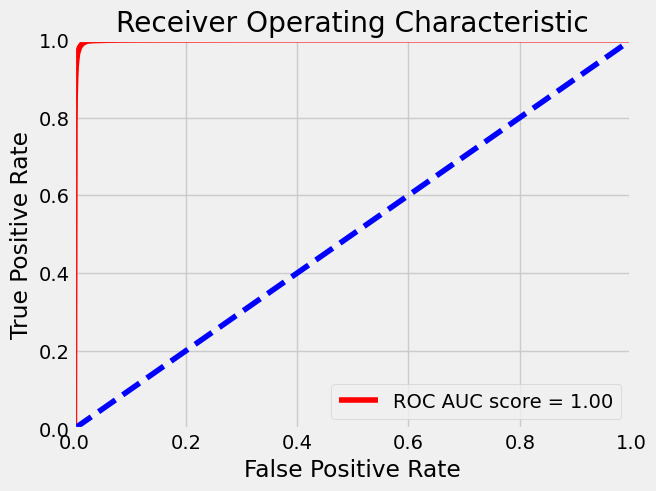

In [56]:
clf = classifier

probs = clf.predict_proba(X_test)
preds = probs[:, 1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'red', label = 'ROC AUC score = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Permutaion importance

In [78]:
%%time
permutation_importance_results = permutation_importance(classifier,
                                                        X=X_test,
                                                        y=y_test,
                                                        n_repeats=100,
                                                        random_state=42)

KeyboardInterrupt: 

Text(0.5, 0, 'Permutation Importance')

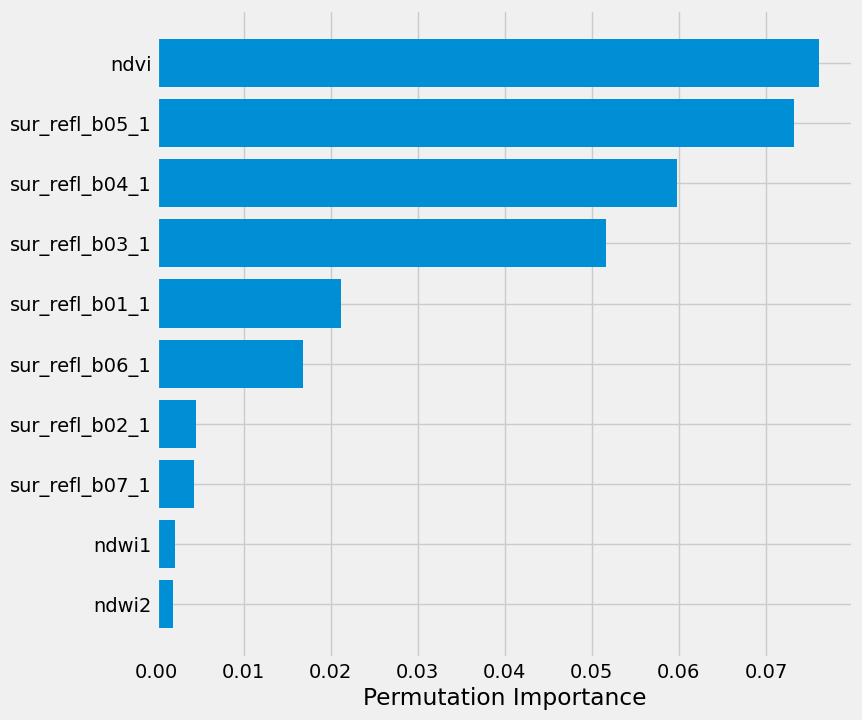

In [59]:
png_save_path = 'mw_{}_{}_{}_{}_{}_permutation_importance.png'.format(
    TILE,
    score,
    hyperparameters['n_estimators'],
    MODEL,
    datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))

png_save_path = os.path.join(FIGURE_OUTPUT_DIR, png_save_path)

sorted_idx = permutation_importance_results.importances_mean.argsort()
plt.figure(figsize=(8, 8))
plt.barh(X_test.columns[sorted_idx], permutation_importance_results.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
# plt.savefig(png_save_path)

Garbage collection

In [28]:
del X_train, X_test, y_train, y_test, test_predictions, train_predictions, y_test_int

## Save the model for future use

In [29]:
model_save_path = 'mw_{}_{}_{}_{}_{}_2.0.0_tuned_{}.sav'.format(TILE,
                                                              score,
                                                              hyperparameters['n_estimators'],
                                                              MODEL,
                                                              'cpu',
                                                              datetime.datetime.now().strftime('%Y_%m_%d_%H_%M'))
model_save_path = os.path.join(MODEL_OUTPUT_DIR, model_save_path)
print('Saving model to: {}'.format(model_save_path))
print(classifier)
joblib.dump(classifier, model_save_path, compress=3)

Saving model to: /explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/mw_Golden_0.983_400_rf_cpu_2.0.0_tuned_2023_02_16_11_48.sav
RandomForestClassifier(max_features='auto', n_estimators=400, n_jobs=-1,
                       random_state=42, warm_start=True)


['/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/models/mw_Golden_0.983_400_rf_cpu_2.0.0_tuned_2023_02_16_11_48.sav']

# Testing: raster testing

In [6]:
import sys
sys.path.append('../../..')
from modis_water_training.model.TabularModisDataGenerator import TabularModisDataGenerator

In [61]:
#only change the day/tile/year

TILE = 'h11v10'
DAY = 201
YEAR = 2006
PATH = os.path.join(test_data_basepath, '{}/'.format(TILE))

In [ ]:
tabularGen = TabularModisDataGenerator(tile=TILE, year=YEAR, julianDays=[DAY])
sensorDir = f'/css/modis/Collection6.1/L2G/MOD09GA/{YEAR}'
modisFilesDict = tabularGen._readFiles(julianDay=DAY, sensorDir=sensorDir)
modisFilesList = list(modisFilesDict.values())
qa_mask, qa_mask_path = tabularGen._generateBadDataMask(day=DAY, files=modisFilesDict)

In [63]:
vars_list_gq = [fn for fn in modisFilesList
            if 'sur_refl' in fn and 'GQ' in fn]
vars_list_gq.sort()

vars_list_ga = [fn for fn in modisFilesList
            if 'sur_refl' in fn and 'GQ' not in fn]
vars_list_ga.sort()

vars_list = vars_list_gq
vars_list.extend(vars_list_ga)

vars_list

['HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GQ/2006/MOD09GQ.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_2D:sur_refl_b01_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GQ/2006/MOD09GQ.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_2D:sur_refl_b02_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b03_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b04_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b05_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_refl_b06_1',
 'HDF4_EOS:EOS_GRID:"/css/modis/Collection6.1/L2G/MOD09GA/2006/MOD09GA.A2006201.h11v10.061.2020266164349.hdf":MODIS_Grid_500m_2D:sur_r

### Read in data 
We don't need to slice because we have more than enough GPU memory.

In [64]:
def readRasterToArray(vars_list):
    vrt_options = gdal.BuildVRTOptions(xRes=231.656358, yRes=231.656358, separate=True)
    dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_options)
    nrows, ncols = dd.RasterYSize, dd.RasterXSize
    newshp = (ncols*nrows, dd.RasterCount+3)
    img = np.empty(newshp, dtype=np.int16)
    for b in range(len(vars_list)):
        img[:, b] = dd.GetRasterBand(b+1).ReadAsArray().astype(np.int16).ravel()
    dd = None
    img[:, len(vars_list)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(vars_list)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(vars_list)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    if os.path.exists('tmp.vrt'):
        os.remove('tmp.vrt')
    return img

In [65]:
%%time
im = readRasterToArray(vars_list)
print('Raster as ndarray')
print(im)
print('{} MB size'.format((im.size * im.itemsize) / 1000000))

Raster as ndarray
[[ 282 2985  173 ... 8273 2822 6797]
 [ 289 3045  173 ... 8266 2913 6851]
 [ 275 3198  180 ... 8416 3050 6898]
 ...
 [ 317 1559  144 ... 6620  562 4395]
 [ 252 1447  126 ... 7033  770 4863]
 [ 252 1447  126 ... 7033  770 4863]]
460.8 MB size
CPU times: user 7.13 s, sys: 666 ms, total: 7.79 s
Wall time: 12 s


In [66]:
def predictRaster(img_chunk, colsToDrop=None):
    """
    Function given a raster in the form of a nxn matrix, will
    convert the matrix to a GPU/CPU-bound data frame then perform 
    predictions given the loaded model.
    
    Return the prediction matrix, the prediction probabilities
    for each and the dataframe converted to host.
    """
    df = pd.DataFrame(img_chunk, columns=v_names, dtype=np.int16)
    df = df.drop(columns=colsToDrop) if colsToDrop else df
    print('Making predictions from raster')
    predictions = classifier.predict(df).astype(np.int16)
    predictionsProbs = classifier.predict_proba(df).astype(np.float32)
    return predictions, predictionsProbs, df

In [67]:
%%time
predictedRaster, predictedProbaRaster, df = predictRaster(im, colsToDrop=colsToDrop)

Making predictions from raster
CPU times: user 33min 56s, sys: 1min 57s, total: 35min 53s
Wall time: 1min 9s


## Inputreshapet raster: description and histogram

In [38]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sur_refl_b01_1,23040000.0,1140.560665,1527.279099,-28672.0,227.0,463.0,1397.0,11069.0
sur_refl_b02_1,23040000.0,2658.499274,1132.979425,-28672.0,2082.0,2533.0,2899.0,10802.0
sur_refl_b03_1,23040000.0,829.334512,1460.147104,-28672.0,152.0,242.0,685.0,9552.0
sur_refl_b04_1,23040000.0,1086.797176,1447.336811,-28672.0,356.0,496.0,1055.0,10207.0
sur_refl_b05_1,23040000.0,2919.611193,1008.000270,-28672.0,2444.0,2757.0,3154.0,8725.0
sur_refl_b06_1,23040000.0,2214.756003,1198.891539,-28672.0,1332.0,1835.0,2798.0,7891.0
sur_refl_b07_1,23040000.0,1316.849571,1626.572310,-28672.0,431.0,873.0,2086.0,8951.0
ndvi,23040000.0,5099.909421,3622.130717,-32758.0,1772.0,6266.0,8435.0,32762.0
ndwi1,23040000.0,1035.434987,2495.314006,-32758.0,-812.0,825.0,3330.0,32762.0
ndwi2,23040000.0,3787.883306,3553.893702,-32758.0,542.0,4209.0,7222.0,32762.0


#### Reshape the unravelled matrix back to the 4800x4800 raster shape

In [69]:
shp = (4800, 4800)
matrix = np.asarray(predictedRaster)
reshp = matrix.reshape(shp)
reshp.shape

(4800, 4800)

### Import the QA Mask and the Water Mask for the h09v05 TILE

In [70]:
water_list = [fn for fn in glob.glob(os.path.join(waterMaskPath, '{}'.format(YEAR), '*{}*{}_v5.tif'.format(TILE, YEAR)))]
print(os.path.join(waterMaskPath, '{}'.format(YEAR), '*{}*.tif'.format(TILE)))
water_mask_path = water_list[0]
print(water_mask_path)
water_mask = gdal.Open(water_mask_path, gdal.GA_ReadOnly)
waterMaskMatrix = water_mask.GetRasterBand(1).ReadAsArray().astype(np.int16)
waterMask = None

/explore/nobackup/people/mcarrol2/MODIS_water/v5_outputs/2006/*h11v10*.tif
/explore/nobackup/people/mcarrol2/MODIS_water/v5_outputs/2006/MOD44W_h11v10_2006_v5.tif


### Mask out results if QA Mask says pixel is "bad"
Mask out water mask if QA Mask says pixel is "bad"

In [71]:
maskedResult = np.where(qa_mask == 0, reshp, 255)
waterMasked = np.where(qa_mask == 0, waterMaskMatrix, 255)
waterMaskRavel = waterMasked.ravel()
imWater = (waterMaskRavel == 1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


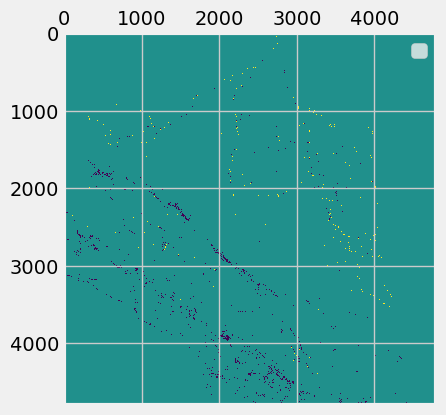

In [80]:
plt.matshow(waterMasked-maskedResult)
plt.legend()

In [ ]:
plt.matshow(waterMasked)

# Generating stats for predicted and truth

## Predicted Raster

In [73]:
import math

In [74]:
tp = np.where((waterMasked == 1) & (maskedResult == 1), 1, 0)
tn = np.where((waterMasked == 0) & (maskedResult == 0), 1, 0)
fp = np.where((waterMasked == 0) & (maskedResult == 1), 1, 0)
fn = np.where((waterMasked == 1) & (maskedResult == 0), 1, 0)
total = np.count_nonzero(waterMasked == 1) + np.count_nonzero(waterMasked == 0)
truePositives = np.count_nonzero(tp == 1)
trueNegatives = np.count_nonzero(tn == 1)
falsePositives = np.count_nonzero(fp == 1)
falseNegatives = np.count_nonzero(fn == 1)
accuracy = (truePositives + trueNegatives) / (truePositives + trueNegatives + falsePositives + falseNegatives)
jians = truePositives / (truePositives + trueNegatives)
pc = truePositives / (truePositives + falsePositives)
rc = truePositives / (truePositives + falseNegatives)
f1 = truePositives / (truePositives + (0.5*(falsePositives + falseNegatives)))
mcc_denom_nosqrt = (truePositives+falsePositives)*(truePositives+falseNegatives)*(trueNegatives+falsePositives)*(trueNegatives+falseNegatives)
mcc_numerator = (truePositives*trueNegatives) - (falsePositives*falseNegatives)
mcc = mcc_numerator/math.sqrt(mcc_denom_nosqrt)

In [75]:
countNoData = np.count_nonzero(maskedResult == 255)
countLand = np.count_nonzero(maskedResult == 0)
countWater = np.count_nonzero(maskedResult == 1)
print('Predicted\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoData, countLand, countWater))

Predicted
 Nodata occurences: 5671456
 Land occurance: 16934742
 Water occurances: 433802


In [76]:
countNoDataT = np.count_nonzero(waterMasked == 255)
countLandT = np.count_nonzero(waterMasked == 0)
countWaterT = np.count_nonzero(waterMasked == 1)
print('Truth Vals\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoDataT, countLandT, countWaterT))

Truth Vals
 Nodata occurences: 5671456
 Land occurance: 17043705
 Water occurances: 324839


### Model metrics on raster data

In [77]:
print('Metrics of Accuracy for Raster Test Data')
print('True Positives:  {}'.format(truePositives))
print('True Negatives:  {}'.format(trueNegatives))
print('False Positives: {}'.format(falsePositives))
print('False Negatives: {}'.format(falseNegatives))
print('Total "good" data: {}'.format(total))
print('Accuracy*: {}'.format(accuracy))
print('Precision: {}'.format(pc))
print('Recall: {}'.format(rc))
print('f1: {}'.format(f1))
print('MCC: {}'.format(mcc))

Metrics of Accuracy for Raster Test Data
True Positives:  286753
True Negatives:  16896656
False Positives: 147049
False Negatives: 38086
Total "good" data: 17368544
Accuracy*: 0.9893407875755158
Precision: 0.6610227707571658
Recall: 0.8827542259396193
f1: 0.7559649425749465
MCC: 0.758848865096568


## Output predicted raster to GeoTiff

In [47]:
outPath = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_{}.tif'.format(YEAR, DAY, TILE, MODEL))
waterMaskForDay = os.path.join(RASTER_OUTPUT_DIR, 'waterMask_{}_qa_{}.tif'.format(YEAR, DAY, TILE, MODEL))
outPathProba = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_probabilities_{}.tif'.format(YEAR, DAY, TILE, MODEL))
print(outPath)
print(waterMaskForDay)
print(outPathProba)

ds = gdal.Open(vars_list[0], gdal.GA_ReadOnly)
geo = ds.GetGeoTransform()
proj = ds.GetProjection()
ncols = ds.RasterXSize
nrows = ds.RasterYSize
print('Transform')
print(geo)
print('Projection')
print(proj)
print('Width')
print(ncols)
print('Height')
print(nrows)
ds = None

# Output predicted binary raster masked with good-bad mask.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(outPath, ncols, nrows, 1, gdal.GDT_Float32, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(maskedResult)
outBand.SetNoDataValue(255)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

# Output water mask with good-bad masked.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(waterMaskForDay, ncols, nrows, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(waterMasked)
outBand.SetNoDataValue(255)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp/2006_201_h11v10_predicted_rf.tif
/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp/waterMask_2006_qa_201.tif
/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp/2006_201_h11v10_predicted_probabilities_rf.tif
Transform
(-7783653.637667, 231.65635826395845, 0.0, -1111950.519667, 0.0, -231.65635826374995)
Projection
PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not specified (based on custom spheroid)",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Width
4800
Height
4800


In [48]:
import folium
from folium import plugins
import glob
import numpy as np
import os
import rasterio as rio
import tempfile

from rasterio.warp import calculate_default_transform, reproject, Resampling
from pyproj import Transformer 

In [49]:
# -----------------------------------------------------------------------------
# Uses rasterio to open a raster, get the metadata and crs
# associated with it and get all the subdatasets in the file.
# This is very useful for hdf files such as MODIS hdfs.
# -----------------------------------------------------------------------------
def print_subdatasets(filename):
    bands_to_return = []
    with rio.open(filename) as dataset:
        meta_data = dataset.meta
        crs = dataset.read_crs()
        
        print([name for name in dataset.subdatasets if search_term in name])

# -----------------------------------------------------------------------------
# Gets a tiff that has the correct metadata for that tile, gets the metadata
# from the source tif and copies to a destination tiff. 
# -----------------------------------------------------------------------------     
def add_metadata_to_annual_product(filepath, model_type, year, tile):
    metadata_pull_src = [fv for fv in glob.glob(os.path.join(filepath, "{}-1*-{}-MOD-*.tif".format(year, tile)))][0]
    with rio.open(metadata_pull_src) as src:
        src_meta = src.meta
    dst_tiffs = [os.path.join(filepath, fn) for fn in os.listdir(filepath) if "{0}-{1}".format(year, tile) in os.path.basename(fn)]
    [copy_meta(dst_tiff, src_meta, metadata_pull_src) for dst_tiff in dst_tiffs]

# -----------------------------------------------------------------------------
# Given a path to a tiff with no metadata, assign the metadata given to that
# tiff.
# -----------------------------------------------------------------------------     
def copy_meta(dst_path, src_meta, src_name):
    print('Copying metadata from {} to {}'.format(src_name, dst_path))
    with rio.open(dst_path, 'r+') as dst:
        dst.crs = src_meta['crs']
        dst.transform = src_meta['transform']        

# -----------------------------------------------------------------------------
# Given a tiff file as input, open the tiff and get the transform needed to
# reproject from the tiff's source crs to the one we want (EPSG:3857).
# For each band in the tiff, open then reproject it into the desired crs
# then write to a temporary file. Return the path to the temp file.
# -----------------------------------------------------------------------------
def reproject_to_3857(input_tiff):
    # Set desitnation CRS
    dst_crs = f"EPSG:3857"

    # set out path
    out_path_rproj = os.path.join(tempfile.gettempdir(), input_tiff.split('/')[-1].replace('.tif','-3857.tif'))

    with rio.open(input_tiff) as src:
        # get src bounds and transform
        transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
        print('Transform: {}'.format(transform))
        print('Width: {} Height: {}'.format(width, height))
        kwargs = src.meta.copy()
        kwargs.update({'crs': dst_crs,
                   'transform': transform,
                   'width': width,
                   'height': height})
    
        # reproject and write to file
        with rio.open(out_path_rproj, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(source=rio.band(src, i),
                      destination=rio.band(dst, i),
                      src_transform=src.transform,
                      src_crs=src.crs,
                      dst_transform=transform,
                      dst_crs=dst_crs,
                      resampling=Resampling.nearest)
    return out_path_rproj

# -----------------------------------------------------------------------------
# In order for folium to work properly we need to pass it the bounding box
# of the tiff in the form of lat and lon. This is done by using rasterio.
# -----------------------------------------------------------------------------
def get_bounds(tiff_3857):
    with rio.open(tiff_3857) as src:
        src_crs = src.crs['init'].upper()
        min_lon, min_lat, max_lon, max_lat = src.bounds
    bounds_orig = [[min_lat, min_lon], [max_lat, max_lon]]
    bounds = []
    dst_crs = 'EPSG:4326'
    for item in bounds_orig:   
        #converting to lat/lon
        lat = item[0]
        lon = item[1]
        proj = Transformer.from_crs(int(src_crs.split(":")[1]), int(dst_crs.split(":")[1]), always_xy=True)
        lon_n, lat_n = proj.transform(lon, lat)
        bounds.append([lat_n, lon_n])
    center_lon = bounds[0][1] + (bounds[1][1] - bounds[0][1])/2
    center_lat = bounds[0][0] + (bounds[1][0] - bounds[0][0])/2
    return {'bounds': bounds, 'center': (center_lon, center_lat)}

# -----------------------------------------------------------------------------
# Use rasterio to open and read in the desired band name as a nd-array.
# -----------------------------------------------------------------------------
def open_and_get_band(file_name, band_num=1):
    with rio.open(file_name) as data:
        b = data.read(band_num)
    return b

# -----------------------------------------------------------------------------
# Given an nd-array (band) and the bounds in lat lon of the nd-array, return
# a folium layer. To add on the map.
# -----------------------------------------------------------------------------
def get_overlay(band, meta_dict, name, opacity=1.0, show=True):
    return folium.raster_layers.ImageOverlay(band, 
                                             bounds=meta_dict['bounds'], 
                                             name=name, 
                                             opacity=opacity, 
                                             show=show)

# -----------------------------------------------------------------------------
# We don't need to keep those temp files we made for the reprojections around.
# -----------------------------------------------------------------------------
def cleanup(filename):
    if os.path.exists(filename):
        os.remove(filename)
    else:
        print('No file: {} exists.'.format(filename))

In [53]:
outPath

'/explore/nobackup/projects/ilab/scratch/cssprad1/MODIS_water/code/tmp/2006_201_h11v10_predicted_rf.tif'

In [55]:
mask_3857 = reproject_to_3857(outPath)
mod44_3857 = reproject_to_3857(water_mask_path)
qa_3857 = reproject_to_3857(qa_mask_path)

mask_d = get_bounds(mask_3857)
mod44_d = get_bounds(mod44_3857)
qa_d = get_bounds(qa_3857)

mask_b1 = open_and_get_band(mask_3857, 1)
mask_b1 = np.where(mask_b1 == 255, 0, mask_b1)
mod44_b1 = open_and_get_band(mod44_3857, 1)
mod44_b1 = np.where(mod44_b1 == 255, 0, mod44_b1)
qa_b1 = open_and_get_band(qa_3857, 1)

cleanup(mask_3857)
cleanup(mod44_3857)
cleanup(qa_3857)

zeros = np.zeros_like(mask_b1)
mask_rgba = np.dstack((mask_b1, zeros, zeros, mask_b1))
mod44_rgba = np.dstack((zeros, mod44_b1, zeros, mod44_b1))
qa_rgba = np.dstack((qa_b1, qa_b1, qa_b1, qa_b1))

Transform: | 207.27, 0.00,-8292460.94|
| 0.00,-207.27,-1118889.97|
| 0.00, 0.00, 1.00|
Width: 7286 Height: 5568
Transform: | 207.27, 0.00,-8292471.14|
| 0.00,-207.27,-1118891.21|
| 0.00, 0.00, 1.00|
Width: 7286 Height: 5568
Transform: | 207.27, 0.00,-8292460.94|
| 0.00,-207.27,-1118889.97|
| 0.00, 0.00, 1.00|
Width: 7286 Height: 5568


In [56]:
m = folium.Map(location=[mask_d['center'][1], mask_d['center'][0]],
                   tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}', zoom_start = 6, attr='Google', control_scale=True)


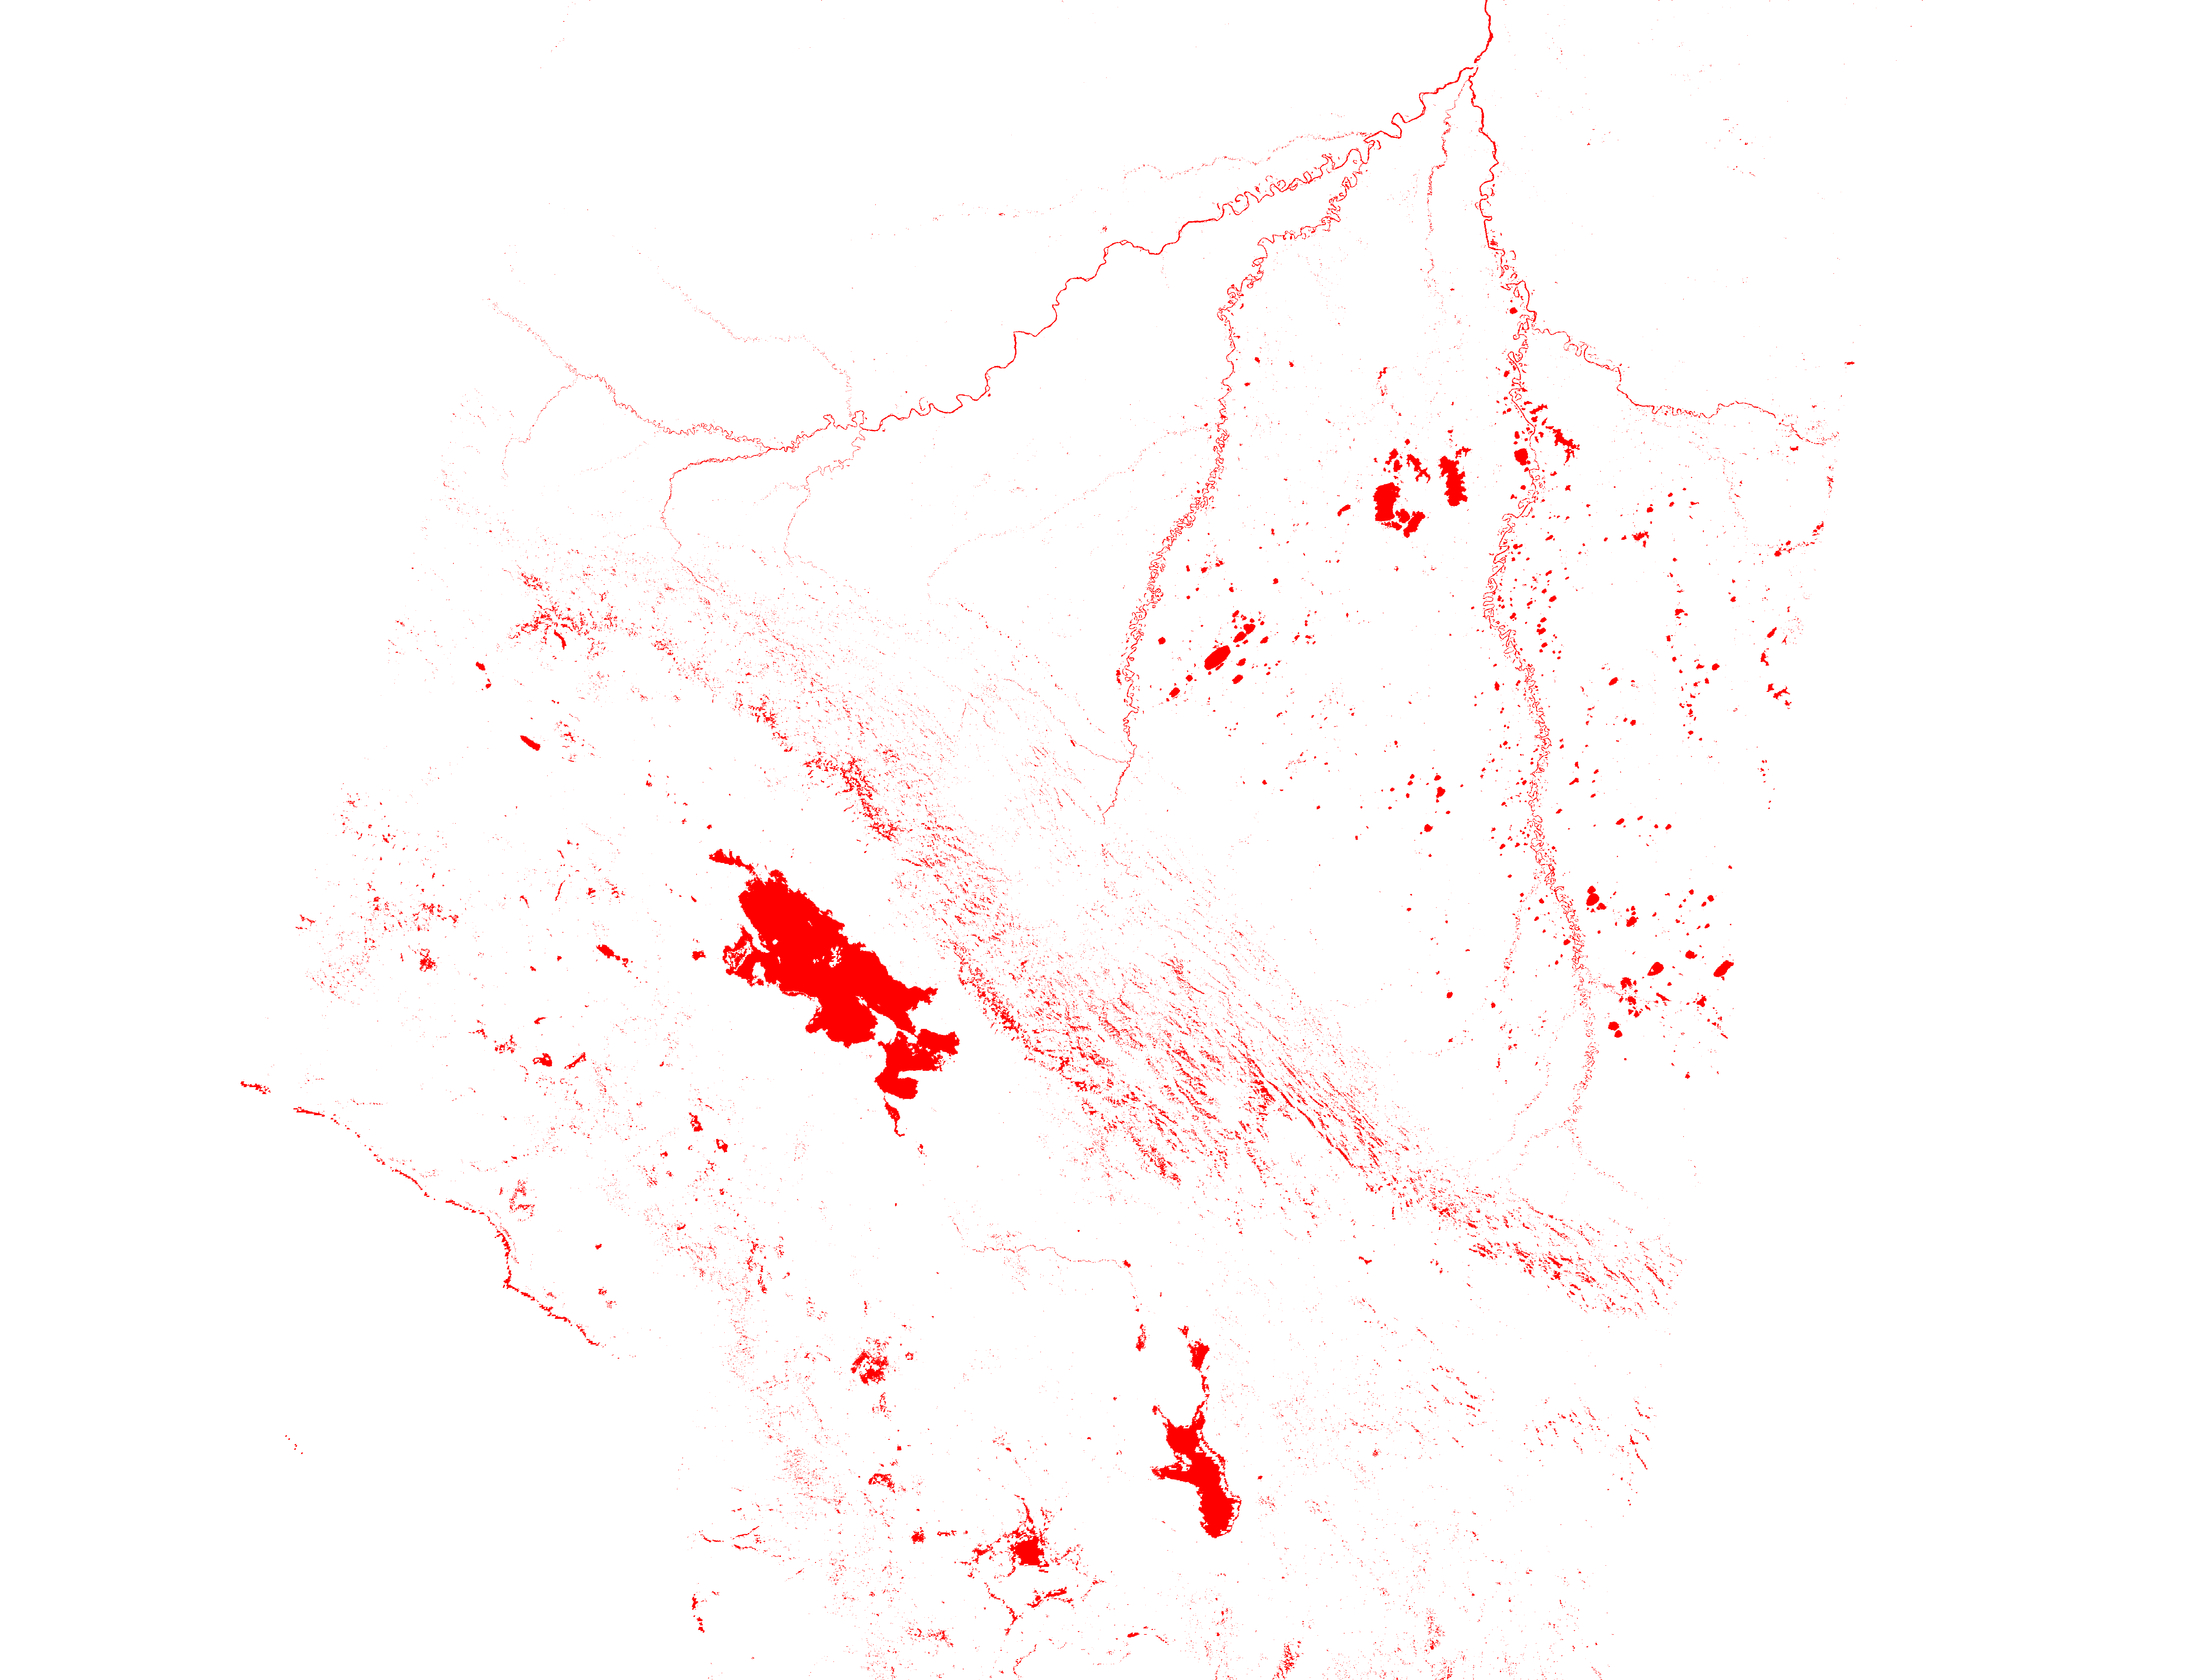
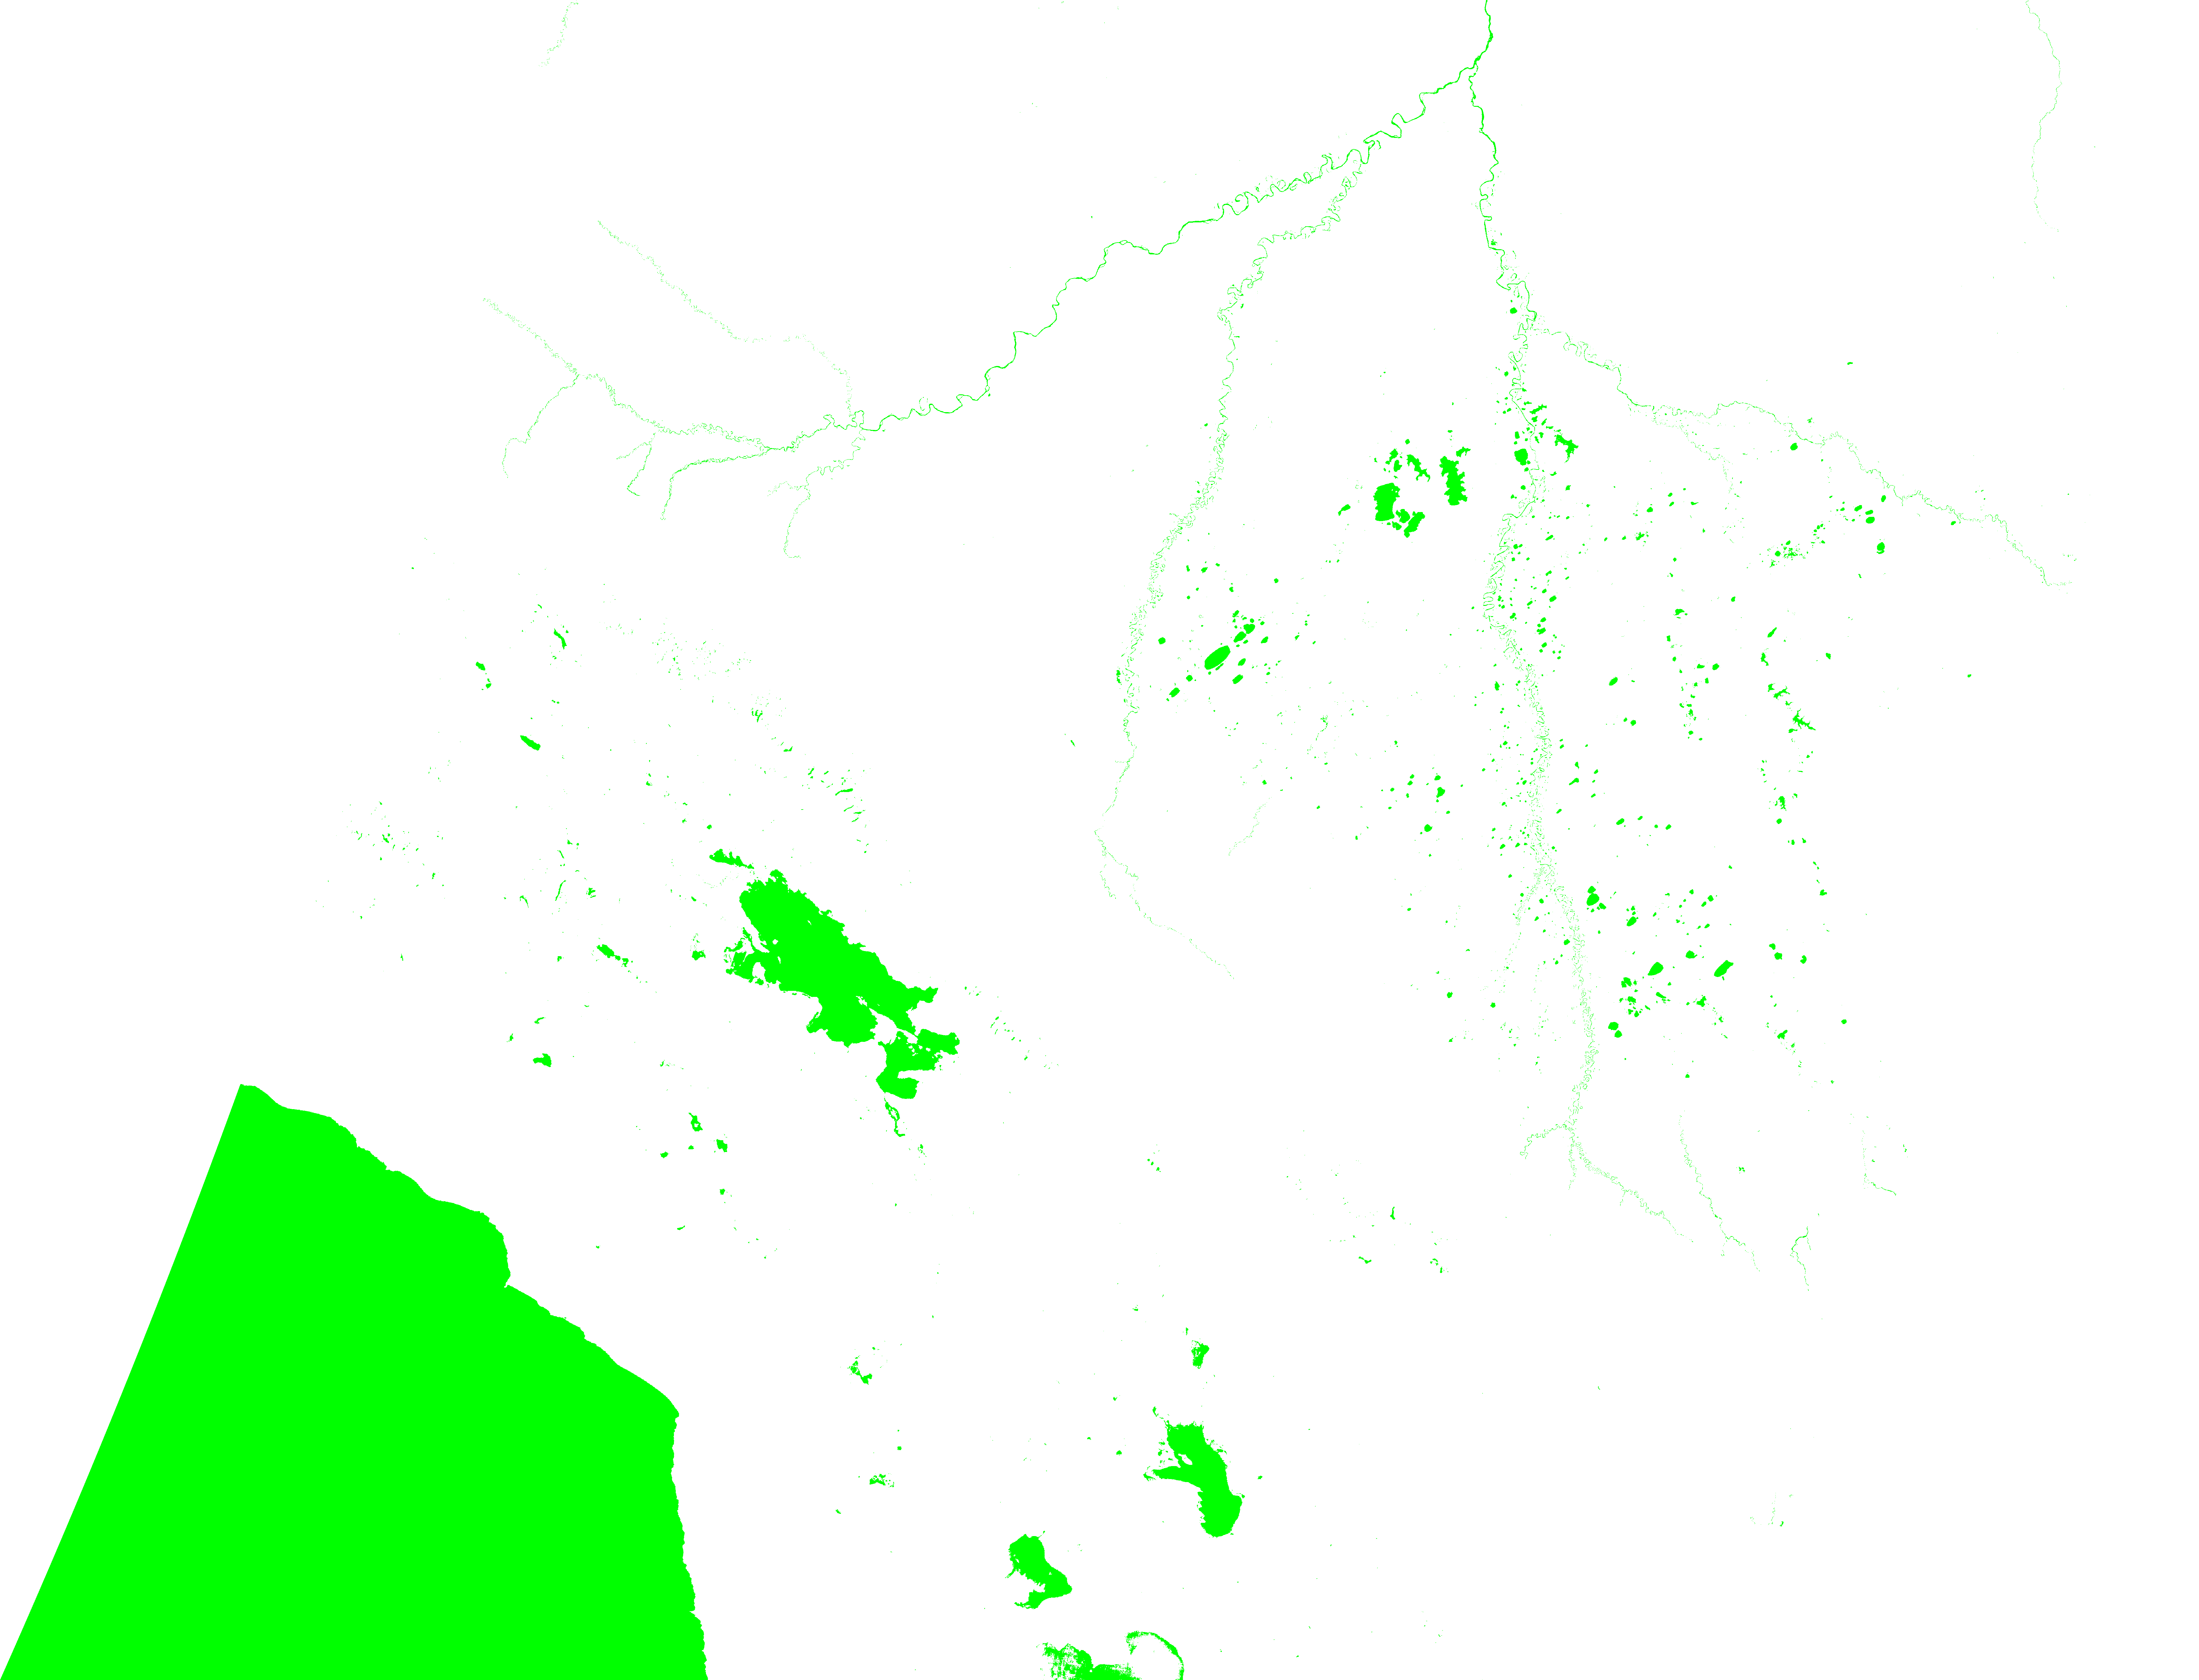
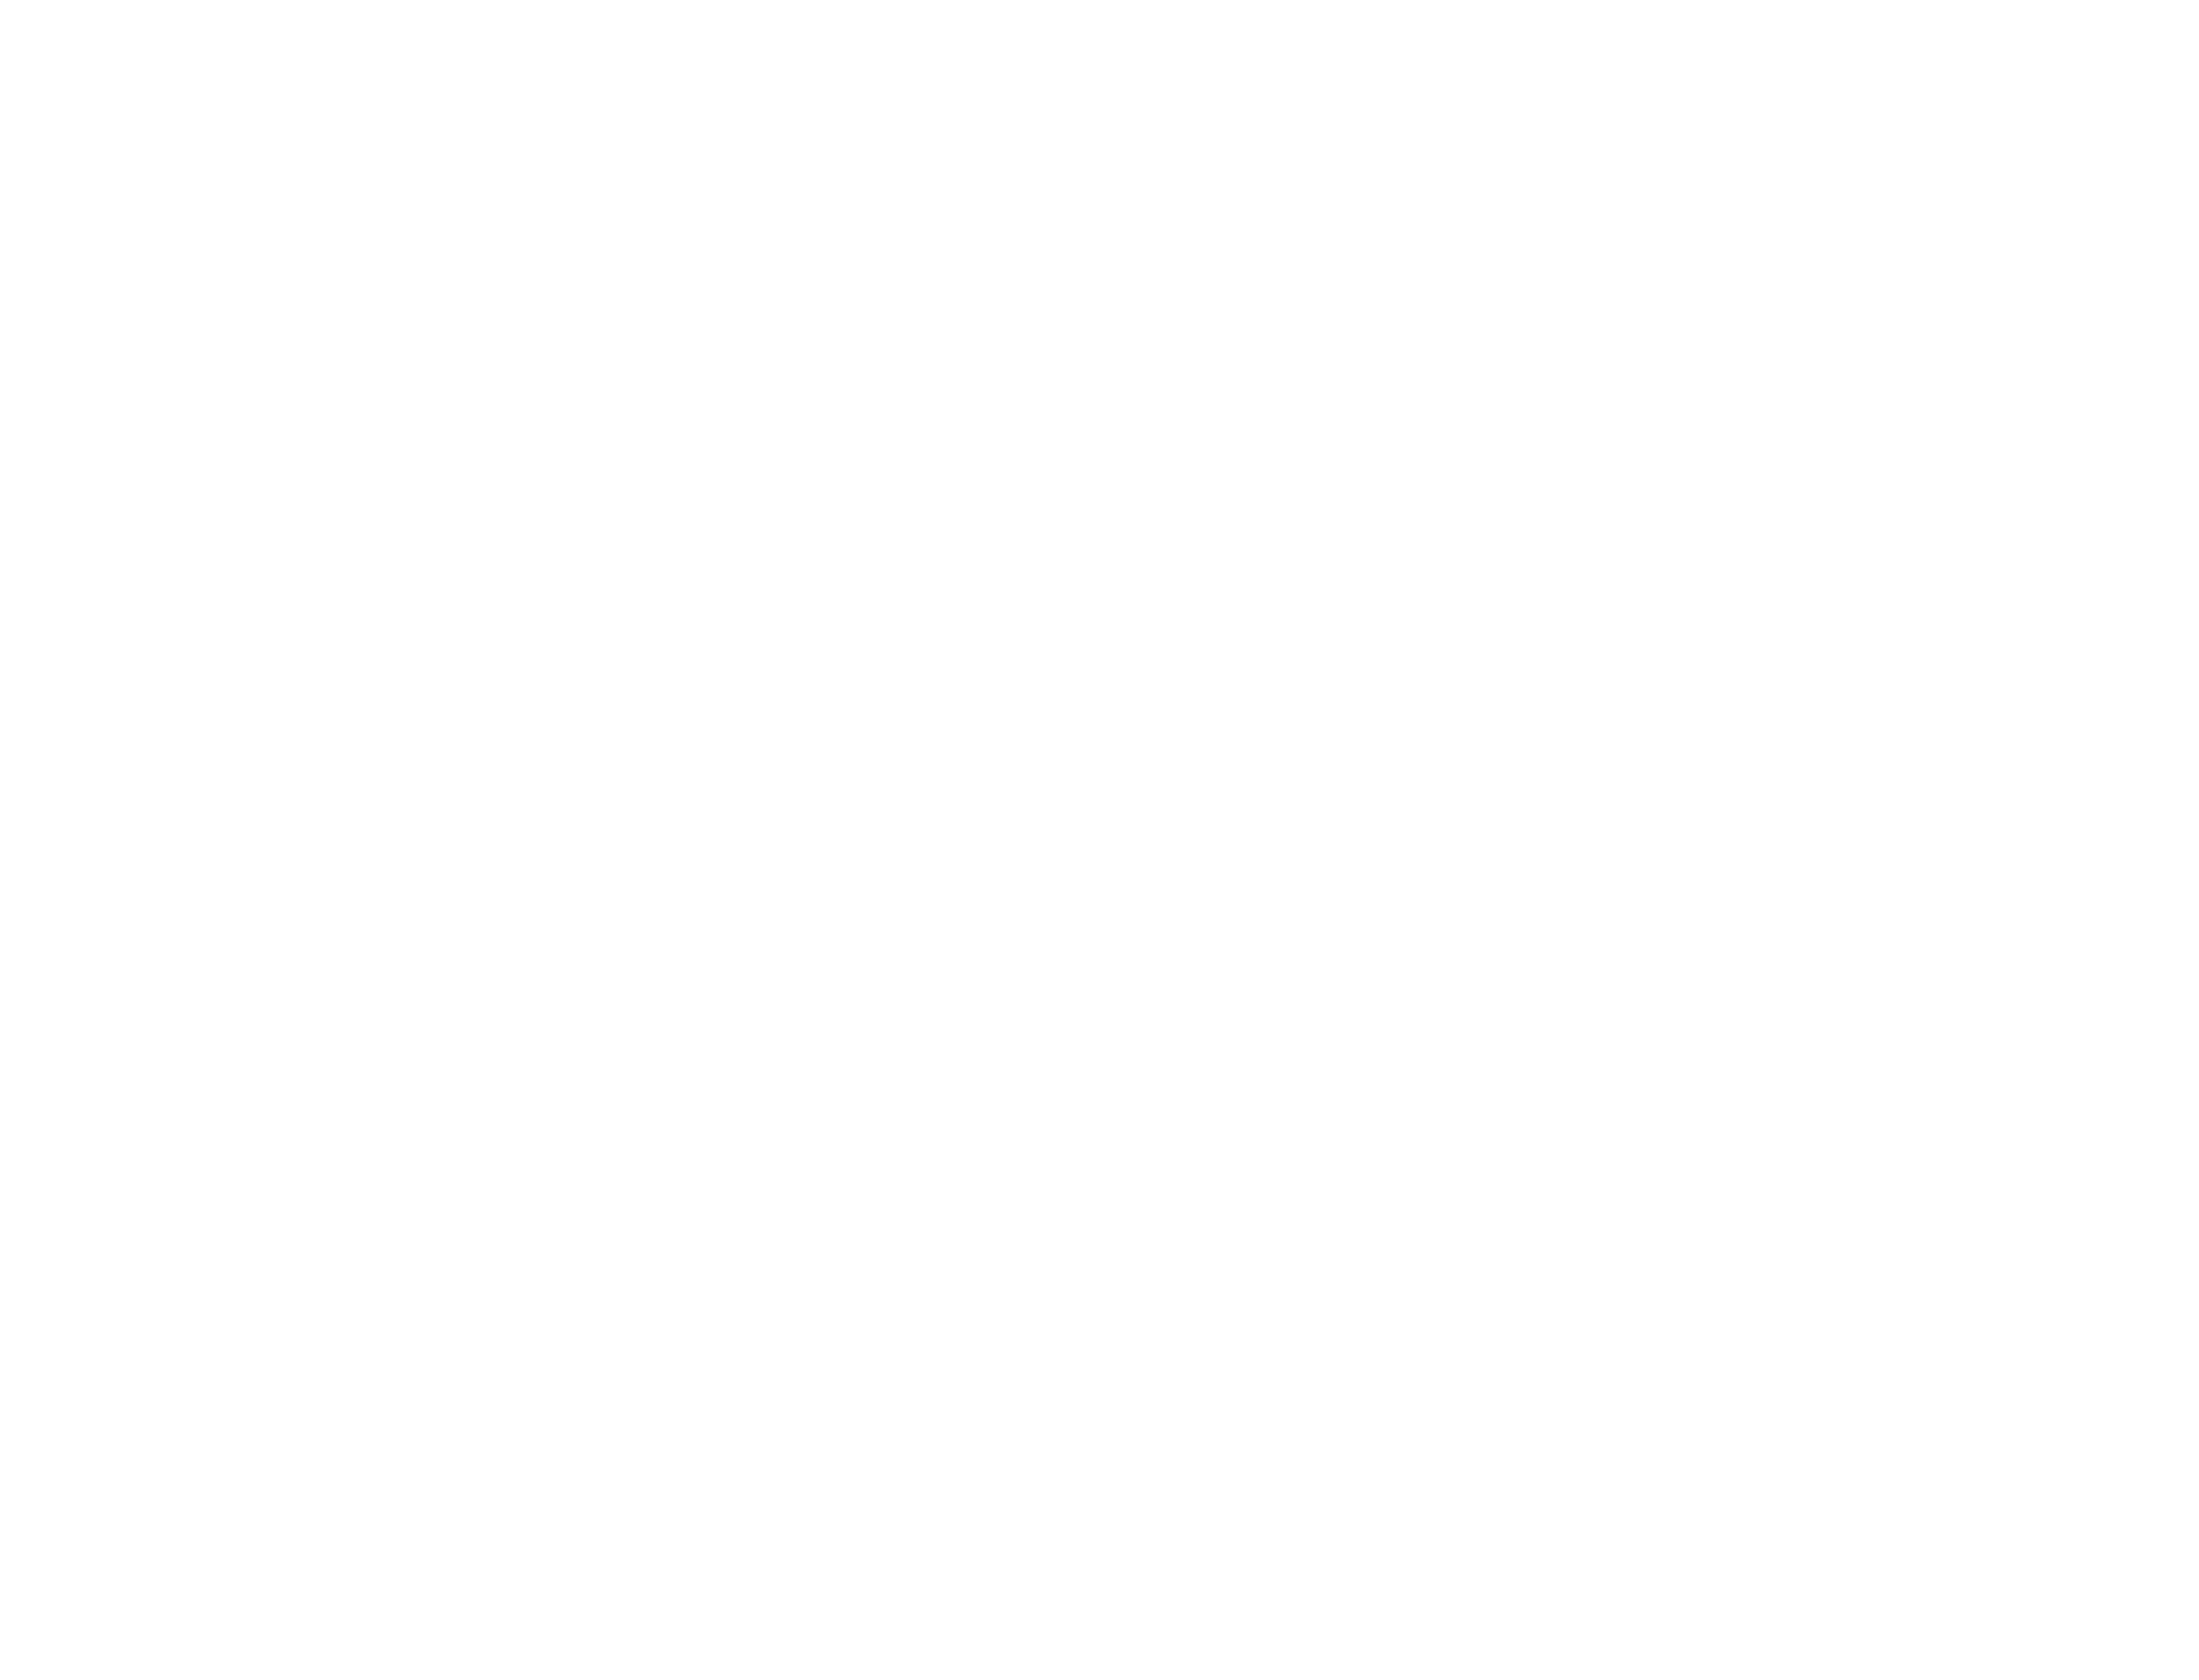

In [57]:
m.add_child(get_overlay(mask_rgba, mask_d, '{}-{}-{} model water mask'.format(YEAR, DAY, TILE), opacity=0.8))
m.add_child(get_overlay(mod44_rgba, mod44_d, '{} {} MOD44W mask'.format(TILE, YEAR), opacity=0.8, show=False))
m.add_child(get_overlay(qa_rgba, qa_d, '{}-{}-{} MW QA mask'.format(YEAR, DAY, TILE), opacity=0.8, show=False))
m.add_child(plugins.MousePosition())
m.add_child(plugins.MeasureControl())
m.add_child(folium.LayerControl())